In [1]:
import os
import warnings
import argparse

import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

import Riff

os.environ['R_HOME'] = '/usr/lib/R'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings("ignore")
palette = sns.color_palette(sns.color_palette("tab20b") + sns.color_palette("tab20c"))

# 1. Set Parameters

In [2]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument("--seeds", type=int, default=0)
parser.add_argument("--device", type=int, default=4)
parser.add_argument("--warmup_steps", type=int, default=-1)
parser.add_argument("--num_heads", type=int, default=4, help="number of hidden attention heads")
parser.add_argument("--num_out_heads", type=int, default=1, help="number of output attention heads")
parser.add_argument("--residual", action="store_true", default=False, help="use residual connection")
parser.add_argument("--in_drop", type=float, default=0.2, help="input feature dropout")
parser.add_argument("--attn_drop", type=float, default=0.1, help="attention dropout")
parser.add_argument("--weight_decay", type=float, default=2e-4, help="weight decay")
parser.add_argument("--negative_slope", type=float, default=0.2, help="the negative slope of leaky relu for GAT")
parser.add_argument("--drop_edge_rate", type=float, default=0.0)
parser.add_argument("--optimizer", type=str, default="adam")
parser.add_argument("--lr_f", type=float, default=0.01, help="learning rate for evaluation")
parser.add_argument("--weight_decay_f", type=float, default=1e-4, help="weight decay for evaluation")
parser.add_argument("--linear_prob", action="store_true", default=True)
parser.add_argument("--load_model", action="store_true")
parser.add_argument("--save_model", action="store_true")
parser.add_argument("--use_cfg", action="store_true")
parser.add_argument("--logging", action="store_true")
parser.add_argument("--scheduler", action="store_true", default=True)

# for graph classification
parser.add_argument("--pooling", type=str, default="mean")
parser.add_argument("--deg4feat", action="store_true", default=False, help="use node degree as input feature")
parser.add_argument("--batch_size", type=int, default=32)

# adjustable parameters
parser.add_argument("--encoder", type=str, default="gat")
parser.add_argument("--decoder", type=str, default="gat")
parser.add_argument("--num_hidden", type=int, default=64, help="number of hidden units")
parser.add_argument("--num_layers", type=int, default=2, help="number of hidden layers")
parser.add_argument("--activation", type=str, default="elu")
parser.add_argument("--max_epoch", type=int, default=50000, help="number of training epochs")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
parser.add_argument("--alpha_l", type=float, default=2, help="`pow`inddex for `weighted_mse` loss")
parser.add_argument("--beta_l", type=float, default=1, help="`pow`inddex for `weighted_mse` loss")   
parser.add_argument("--loss_fn", type=str, default="weighted_mse")
parser.add_argument("--mask_gene_rate", type=float, default=0.3)
parser.add_argument("--replace_rate", type=float, default=0.05)
parser.add_argument("--remask_rate", type=float, default=0.)
parser.add_argument("--warm_up", type=int, default=50)
parser.add_argument("--norm", type=str, default="batchnorm")

# GSG parameter
parser.add_argument("--batch_node", type=int, default=4096)
parser.add_argument("--num_neighbors", type=int, default=7)
parser.add_argument("--num_features", type=int, default=3000)
parser.add_argument("--ref_name", type=list, default=["MouseOlfactoryBulb"])
parser.add_argument("--target_name", type=str, default="151507")
parser.add_argument("--cluster_label", type=str, default= "fine_annot_type")
parser.add_argument("--folder_name", type=str, default="/home/wcy/code/datasets/10X/")  
parser.add_argument("--num_classes", type=int, default=20, help = "The number of clusters")
parser.add_argument("--radius", type=int, default=7)

# read parameters
args = parser.parse_args(args=['--target_name', 'V1_Breast_Cancer_Block_A_Section_2',
                              '--ref_name', ['V1_Breast_Cancer_Block_A_Section_1']]) 
args

Namespace(activation='elu', alpha_l=2, attn_drop=0.1, batch_node=4096, batch_size=32, beta_l=1, cluster_label='fine_annot_type', decoder='gat', deg4feat=False, device=4, drop_edge_rate=0.0, encoder='gat', folder_name='/home/wcy/code/datasets/10X/', in_drop=0.2, linear_prob=True, load_model=False, logging=False, loss_fn='weighted_mse', lr=0.001, lr_f=0.01, mask_gene_rate=0.3, max_epoch=50000, negative_slope=0.2, norm='batchnorm', num_classes=20, num_features=3000, num_heads=4, num_hidden=64, num_layers=2, num_neighbors=7, num_out_heads=1, optimizer='adam', pooling='mean', radius=7, ref_name=['V1_Breast_Cancer_Block_A_Section_1'], remask_rate=0.0, replace_rate=0.05, residual=False, save_model=False, scheduler=True, seeds=0, target_name='V1_Breast_Cancer_Block_A_Section_2', use_cfg=False, warm_up=50, warmup_steps=-1, weight_decay=0.0002, weight_decay_f=0.0001)

# 2. Preprocession

In [3]:
adata_ref_list = []
for ref_name in args.ref_name:
    data_path = os.path.join(args.folder_name, ref_name)
    adata_ref = Riff.read_10X_Visium_with_label(data_path)

    num_classes = adata_ref.obs[args.cluster_label].nunique()
    adata_ref.obs[args.cluster_label] = adata_ref.obs[args.cluster_label].astype('category')
    adata_ref_list.append(adata_ref)

data_path = os.path.join(args.folder_name, args.target_name)
adata_target = Riff.read_10X_Visium_with_label(data_path)
        
adata_ref_list, adata_target, graph_ref_list, graph_target = Riff.transfer_preprocess(args, adata_ref_list, adata_target)

=============== Contructing graph =================


# 3. Training and spatial domain identification

=============== Building model ===============
batch nodes change from 4096 to 3798.
===================== Start training =======================


# Epoch 335: train_loss: 0.25, recon_loss: 0.25, cls_loss: 0.25:   1%|▉                                                                                                                                                 | 336/50000 [00:17<42:37, 19.42it/s]
... storing 'feature_types' as categorical
... storing 'genome' as categorical


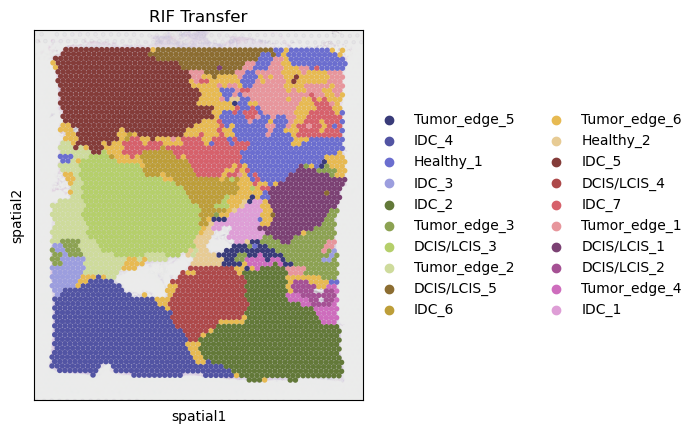

In [4]:
adata_ref, adata_target = Riff.transfer_train(args, adata_ref_list, graph_ref_list, adata_target, graph_target, num_classes)
adata_target.obs['cluster_pred'] = adata_target.obs['cluster_pred'].astype(int).astype('category')

map_dict = {}
cat = graph_ref_list[0].ndata['label'].unique()
for c in cat:
    index = np.where(graph_ref_list[0].ndata['label'] == c)[0][0]
    map_dict[int(c)] = str(adata_ref_list[0].obs[args.cluster_label][index])

adata_target.obs['RIF Transfer'] = adata_target.obs['cluster_pred'].map(map_dict)
sc.pl.spatial(adata_target, color=[ 'RIF Transfer'], title=['RIF Transfer'], s=12, alpha_img=0.3, palette=palette)